In [44]:
import pyfet
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

Eg = 0.36
epsOX = 8.5
epsS = 8.9
tOX = 20e-9
temperature = 300
ems = 0.067
W1 = 50e-9
W2 = 8e-9
alpha = pyfet.alpha_NP(Eg, ems)
Cox = pyfet.Cox_rect(epsOX, tOX, W1, W2)
Cc = pyfet.Cc_rect(epsS, W1, W2)
alpha_D = 0
alpha_G = 1

p = pyfet.param_ballistic_new()
p.ems = ems
p.alpha = alpha
p.W1 = W1
p.W2 = W2

p.EFermi = -0.1
p.alpha_D = alpha_D
p.alpha_G = alpha_G
p.Ceff = Cox*Cc/(Cox+Cc)
p.temp = temperature
p.nmax = 8
p.mmax = 2

In [31]:
def density1d_circ1d_all0(EFermi, ems, temp, radius, nmax):
    n0=0
    nlist = np.arange(1, nmax+1, dtype=np.int64)
    for n in nlist:
        Enp=pyfet.Ep_n_radial1d(ems,radius,int(n))
        n0 += pyfet.density1d0(EFermi,Enp,ems,temp)
    return(n0)

def func_e0_find(E0, p, Vgs, Vds):
    n1d_S = density1d_circ1d_all0(p.EFermi - E0 , p.ems, p.temp, p.W1, p.nmax)
    n1d_D = density1d_circ1d_all0(p.EFermi - E0 - Vds , p.ems, p.temp, p.W1, p.nmax)
    q0 = 1.6e-19 * (n1d_S + n1d_D) / (2 * p.Ceff)
    return E0 + (p.alpha_D * Vds + p.alpha_G * Vgs - q0)

def get_E0(p, Vgs, Vds):
    e0 = optimize.root_scalar(func_e0_find, args=(p, Vgs, Vds), x0=-0.1, x1=1)
    return e0.root

def func_FD0(ene, temp):
    return math.log(1+math.exp(ene*1.6e-19/(1.38e-23*temp)))

def func_current1D(Vds, Vgs, p, EFs):
    e0 = optimize.root_scalar(func_e0_find, args=(p, Vgs, Vds), x0=-0.1, x1=1)
    # e0=get_E0(p, Vgs, Vds)
    nlist = np.arange(1, p.nmax+1, dtype=np.int64)
    cur = 0
    for n in nlist:
        Enp = pyfet.Ep_n_radial1d(ems, W1, int(n))
        cur1 = func_FD0(EFs-Enp-e0.root, p.temp)
        cur2 = func_FD0(EFs-Enp-e0.root-Vds, p.temp)
        cur += cur1-cur2

    return (cur*2*1.6e-19/6.63e-34*p.temp*1.38e-23)

In [32]:
func_current1D(0.5,0,p,0)/(2*math.pi*p.W1)

7.84071963434119

In [33]:
def determine_EFs(p, Vds, Ids):
    e0 = optimize.root_scalar(
        func_det_EFs, args=(p, Vds, Ids), x0=-0.1, x1=0.1)
    return e0.root


def func_det_EFs(EFs, p, Vds, Ids):
    return Ids - func_current1D(Vds, 0, p, EFs)/(2*math.pi*p.W1)

In [48]:
Vds = 0.5
EFs=determine_EFs(p, Vds, 100e-9*1e6)
print(EFs)

-0.13255366552515588


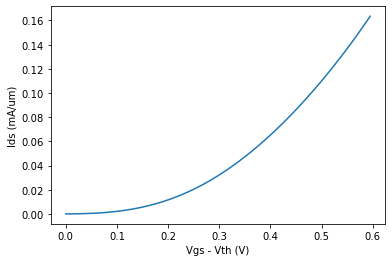

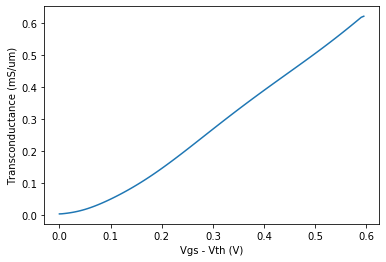

In [46]:
dVgs = 0.005
Vgs = np.arange(0, 0.6, dVgs)
Ids1 = np.empty_like(Vgs)
for i, Vgs0 in enumerate(Vgs):
    Ids1[i] = func_current1D(Vds, Vgs0, p, EFs)/(2*math.pi*p.W1)*1e-3

gm1 = np.gradient(Ids1, dVgs)

plt.plot(Vgs, Ids1, label='Ids1')
plt.xlabel('Vgs - Vth (V)')
plt.ylabel('Ids (mA/um)')
plt.show()

plt.plot(Vgs, gm1, label='gm')
plt.xlabel('Vgs - Vth (V)')
plt.ylabel('Transconductance (mS/um)')
plt.show()